<a href="https://colab.research.google.com/github/Solunska/LongCovid-sentiment-analysis/blob/master/LongCovid_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint

# Importing the data

In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_test.csv', encoding='latin-1')
df_train = pd.read_csv('/content/drive/MyDrive/datasets/Corona_NLP_train.csv', encoding='latin-1')

# Data exploration

In [4]:
df = pd.concat([df_test, df_train])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


# Data preparation

## Removing the unnecessary columns

In [5]:
df = df.drop(columns=['UserName','ScreenName','Location','TweetAt'])
df

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


Replacing the 'Extremely Negative' and 'Extremely Positive' to 'Negative' and 'Positive' for the needs of the project

In [6]:
df['Sentiment'] = df['Sentiment'].replace({'Extremely Negative': 'Negative', 'Extremely Positive': 'Positive'})

In [7]:
df = df.rename(columns={'OriginalTweet': 'Tweet'})

In [8]:
df

,Tweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


## Distribution of the data

Positive    19592
Negative    17031
Neutral      8332
Name: Sentiment, dtype: int64


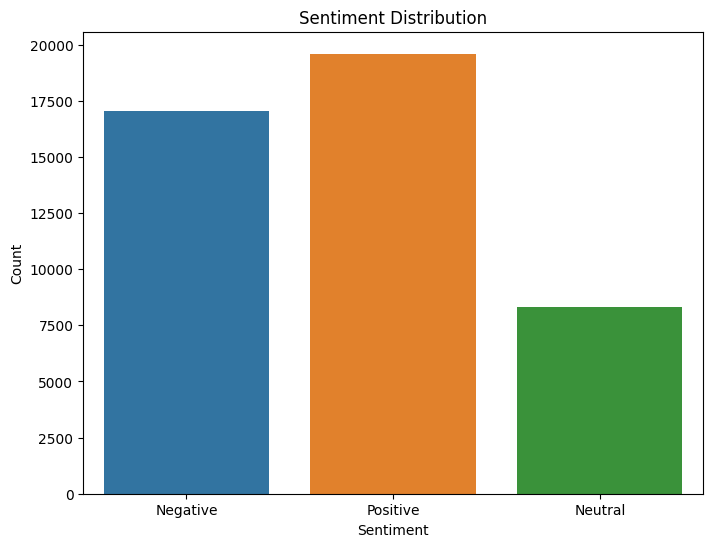

In [15]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Preprocessing the tweets

### Removing URLs, mentions, special characters, punctuation, repeating characters, numbers and making all characters lower case

In [9]:
def preprocess_tweet(tweet):
  tweet = tweet.lower() # lower case
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # removing mentions
  tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet) # removing URLs
  tweet = re.sub(r"[^\w\s]", "", tweet)  # removing special characters and punctuation
  tweet = re.sub(r'(.)1+', r'1', tweet) # removing repeating characters
  tweet = re.sub('[0-9]+', '', tweet) # removing numbers
  return tweet

In [10]:
df['Tweet'] = df['Tweet'].apply(preprocess_tweet)
df

,Tweet,Sentiment
0,trending new yorkers encounter empty supermark...,Negative
1,when i couldnt find hand sanitizer at fred mey...,Positive
2,find out how you can protect yourself and love...,Positive
3,panic buying hits newyork city as anxious shop...,Negative
4,toiletpaper dunnypaper coronavirus coronavirus...,Neutral
...,...,...
41152,airline pilots offering to stock supermarket s...,Neutral
41153,response to complaint not provided citing covi...,Negative
41154,you know itâs getting tough when is rationin...,Positive
41155,is it wrong that the smell of hand sanitizer i...,Neutral


### Removing stopwords

In [11]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
def remove_stop_words(sentence):
  words = sentence.split()
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)

In [13]:
df['Tweet'] = df['Tweet'].apply(remove_stop_words)
df

,Tweet,Sentiment
0,trending new yorkers encounter empty supermark...,Negative
1,couldnt find hand sanitizer fred meyer turned ...,Positive
2,find protect loved ones coronavirus,Positive
3,panic buying hits newyork city anxious shopper...,Negative
4,toiletpaper dunnypaper coronavirus coronavirus...,Neutral
...,...,...
41152,airline pilots offering stock supermarket shel...,Neutral
41153,response complaint provided citing covi relate...,Negative
41154,know itâs getting tough rationing toilet paper...,Positive
41155,wrong smell hand sanitizer starting turn coron...,Neutral


### Lemmatization

Lemmatization is a useful technique in NLP to obtain the root form of words, known as lemmas. For example, the lemma of the words reading, reads, read is read.

In [14]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
df['Tweet'] = df.Tweet.apply(lemmatize_text)
df

[nltk_data] Downloading package wordnet to /root/nltk_data...


,Tweet,Sentiment
0,trending new yorkers encounter empty supermark...,Negative
1,couldnt find hand sanitizer fred meyer turned ...,Positive
2,find protect loved one coronavirus,Positive
3,panic buying hit newyork city anxious shopper ...,Negative
4,toiletpaper dunnypaper coronavirus coronavirus...,Neutral
...,...,...
41152,airline pilot offering stock supermarket shelf...,Neutral
41153,response complaint provided citing covi relate...,Negative
41154,know itâs getting tough rationing toilet paper...,Positive
41155,wrong smell hand sanitizer starting turn coron...,Neutral


In [18]:
data = df

## Label encoding

In [19]:
encoder = LabelEncoder()
data['Sentiment'] = encoder.fit_transform(data['Sentiment'])
data['Sentiment']

0        0
1        2
2        2
3        0
4        1
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: Sentiment, Length: 44955, dtype: int64

In [20]:
data

,Tweet,Sentiment
0,trending new yorkers encounter empty supermark...,0
1,couldnt find hand sanitizer fred meyer turned ...,2
2,find protect loved one coronavirus,2
3,panic buying hit newyork city anxious shopper ...,0
4,toiletpaper dunnypaper coronavirus coronavirus...,1
...,...,...
41152,airline pilot offering stock supermarket shelf...,1
41153,response complaint provided citing covi relate...,0
41154,know itâs getting tough rationing toilet paper...,2
41155,wrong smell hand sanitizer starting turn coron...,1


## Converting the labels into categorical type
(because we'll use categorical_crossentropy loss)

In [21]:
import tensorflow as tf

labels = tf.keras.utils.to_categorical(data['Sentiment'], 3, dtype="float32")
labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## Tokenizing and Sequence Padding

In [22]:
text = np.array(data['Tweet'])
text

array(['trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock ',
       'couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price ',
       'find protect loved one coronavirus ', ...,
       'know itâs getting tough rationing toilet paper coronavirus toiletpaper martinsville help u ',
       'wrong smell hand sanitizer starting turn coronavirus covi coronavirus ',
       'well newused rift going amazon rn although normal market price usually price really crazy right vr headset since hl alex announced worse covi whethe '],
      dtype=object)

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1387  219   19]
 [   0    0    0 ...  413  805    4]
 [   0    0    0 ... 1619   29    1]
 ...
 [   0    0    0 ...   48   28   18]
 [   0    0    0 ...    1    2    1]
 [   0    0    0 ...  511  631    2]]


In [24]:
print(labels)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2)

In [26]:
len(X_train[0])

200

# Building a model

In [27]:
model = Sequential()

model.add(Embedding(max_words, 64, input_length=max_len))

model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the model

In [30]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
450/450 [==============================] - 1178s 3s/step - loss: 0.7383 - accuracy: 0.6775 - val_loss: 0.5237 - val_accuracy: 0.8100
Epoch 2/15
450/450 [==============================] - 1160s 3s/step - loss: 0.4680 - accuracy: 0.8440 - val_loss: 0.4701 - val_accuracy: 0.8379
Epoch 3/15
450/450 [==============================] - 1108s 2s/step - loss: 0.4097 - accuracy: 0.8663 - val_loss: 0.4897 - val_accuracy: 0.8271
Epoch 4/15
450/450 [==============================] - 1277s 3s/step - loss: 0.3672 - accuracy: 0.8812 - val_loss: 0.5048 - val_accuracy: 0.8280
Epoch 5/15
450/450 [==============================] - 1151s 3s/step - loss: 0.3248 - accuracy: 0.8979 - val_loss: 0.5396 - val_accuracy: 0.8207
Epoch 6/15
450/450 [==============================] - 1227s 3s/step - loss: 0.2869 - accuracy: 0.9107 - val_loss: 0.5867 - val_accuracy: 0.8227
Epoch 7/15
450/450 [==============================] - 1141s 3s/step - loss: 0.2483 - accuracy: 0.9232 - val_loss: 0.6328 - val_accuracy:

In [31]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/models/model.h5')

In [32]:
model = load_model('/content/drive/MyDrive/models/model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

## Evaluating the model

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

281/281 [==============================] - 138s 480ms/step - loss: 1.3073 - accuracy: 0.7858
Test Loss: 1.307292103767395, Test Accuracy: 0.7857857942581177


In [34]:
y_pred = model.predict(X_test)

281/281 [==============================] - 127s 445ms/step


In [35]:
y_pred = y_pred.round()

In [36]:
ac = accuracy_score(y_test, y_pred.round())
print('accuracy of the model: ', ac)

accuracy of the model:  0.7834501167834501


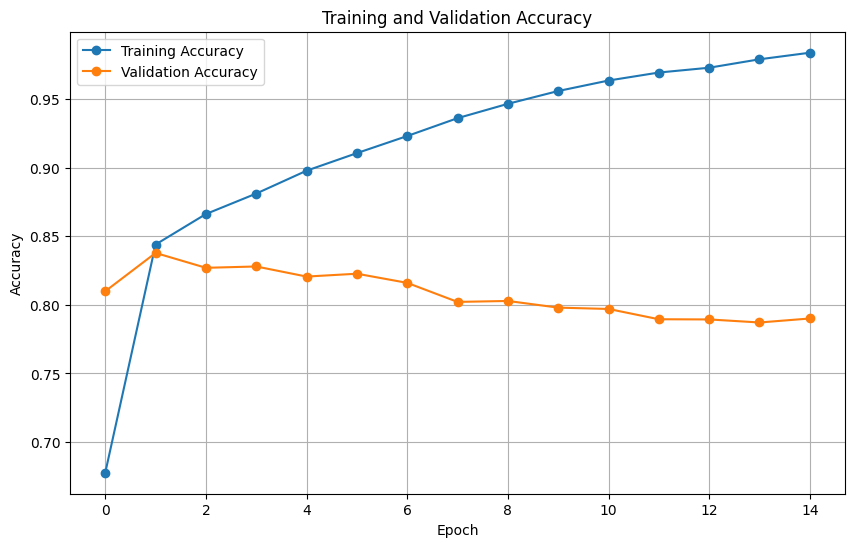

In [38]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']

validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Training Accuracy', marker='o')
plt.plot(validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prediction on the #LongCovid tweets

In [59]:
df = pd.read_csv('/content/drive/MyDrive/lc2020.csv', encoding='latin-1')
df

,Date,User,Tweets
0,2020-04-01 00:23:31+00:00,Jennyjen_k,March was 367 days long. We are now finally em...
1,2020-04-01 01:25:41+00:00,flowers197624,I never seen nothing made in China last so lon...
2,2020-04-01 01:26:29+00:00,Rcarvz,@stoolpresidente I wonder how long Covid lives...
3,2020-04-01 01:38:13+00:00,NaniWaialeale,Many have wondered how long COVID-19 lasts on ...
4,2020-04-01 02:43:35+00:00,graymaxwell1,@realDonaldTrump Pre-existing issues caused my...
...,...,...,...
158275,2020-12-31 23:52:55+00:00,BangkokPostNews,If 2020 was wretched for tourists and the flyi...
158276,2020-12-31 23:54:42+00:00,Jimwylie5,Happy new year everyone out there. Been pretty...
158277,2020-12-31 23:55:28+00:00,KymYSmith,"To all those who have died of covid this year,..."
158278,2020-12-31 23:55:54+00:00,colocha_rachel,"@KhesedBein I get that, but I??ve already had..."


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158280 entries, 0 to 158279
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Date    158280 non-null  object
 1   User    158280 non-null  object
 2   Tweets  158280 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [61]:
df. shape

(158280, 3)

In [62]:
df = df.drop(columns=['Date','User'])
df

,Tweets
0,March was 367 days long. We are now finally em...
1,I never seen nothing made in China last so lon...
2,@stoolpresidente I wonder how long Covid lives...
3,Many have wondered how long COVID-19 lasts on ...
4,@realDonaldTrump Pre-existing issues caused my...
...,...
158275,If 2020 was wretched for tourists and the flyi...
158276,Happy new year everyone out there. Been pretty...
158277,"To all those who have died of covid this year,..."
158278,"@KhesedBein I get that, but I??ve already had..."


In [64]:
df['Tweets'] = df['Tweets'].apply(preprocess_tweet)
df

,Tweets
0,march was days long we are now finally embark...
1,i never seen nothing made in china last so lon...
2,i wonder how long covid lives on car windows for
3,many have wondered how long covi lasts on surf...
4,preexisting issues caused my mother to take t...
...,...
158275,if was wretched for tourists and the flying p...
158276,happy new year everyone out there been pretty ...
158277,to all those who have died of covid this year ...
158278,i get that but ive already had covid and deal...


In [65]:
df['Tweets'] = df['Tweets'].apply(remove_stop_words)
df['Tweets'] = df.Tweets.apply(lemmatize_text)

In [66]:
sequences = tokenizer.texts_to_sequences(df['Tweets'])
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   32  164    3]
 [   0    0    0 ...  676  213  826]
 [   0    0    0 ...  115  337 1726]
 ...
 [   0    0    0 ...  164    3  199]
 [   0    0    0 ...  284  260   64]
 [   0    0    0 ...   60  955  588]]


In [46]:
predictions = model.predict(tweets)

4947/4947 [==============================] - 2277s 460ms/step


In [47]:
predicted_sentiments = [np.argmax(prediction) for prediction in predictions]

In [119]:
data = pd.read_csv('/content/drive/MyDrive/lc2020.csv', encoding='latin-1')

In [120]:
data = data.drop(columns=['User'])

In [121]:
data['Sentiment'] = predicted_sentiments

In [122]:
data

,Date,Tweets,Sentiment
0,2020-04-01 00:23:31+00:00,March was 367 days long. We are now finally em...,1
1,2020-04-01 01:25:41+00:00,I never seen nothing made in China last so lon...,2
2,2020-04-01 01:26:29+00:00,@stoolpresidente I wonder how long Covid lives...,1
3,2020-04-01 01:38:13+00:00,Many have wondered how long COVID-19 lasts on ...,1
4,2020-04-01 02:43:35+00:00,@realDonaldTrump Pre-existing issues caused my...,2
...,...,...,...
158275,2020-12-31 23:52:55+00:00,If 2020 was wretched for tourists and the flyi...,0
158276,2020-12-31 23:54:42+00:00,Happy new year everyone out there. Been pretty...,2
158277,2020-12-31 23:55:28+00:00,"To all those who have died of covid this year,...",0
158278,2020-12-31 23:55:54+00:00,"@KhesedBein I get that, but I??ve already had...",0


In [123]:
data['PreprocessedTweets'] = data['Tweets'].apply(preprocess_tweet)
data

,Date,Tweets,Sentiment,PreprocessedTweets
0,2020-04-01 00:23:31+00:00,March was 367 days long. We are now finally em...,1,march was days long we are now finally embark...
1,2020-04-01 01:25:41+00:00,I never seen nothing made in China last so lon...,2,i never seen nothing made in china last so lon...
2,2020-04-01 01:26:29+00:00,@stoolpresidente I wonder how long Covid lives...,1,i wonder how long covid lives on car windows for
3,2020-04-01 01:38:13+00:00,Many have wondered how long COVID-19 lasts on ...,1,many have wondered how long covi lasts on surf...
4,2020-04-01 02:43:35+00:00,@realDonaldTrump Pre-existing issues caused my...,2,preexisting issues caused my mother to take t...
...,...,...,...,...
158275,2020-12-31 23:52:55+00:00,If 2020 was wretched for tourists and the flyi...,0,if was wretched for tourists and the flying p...
158276,2020-12-31 23:54:42+00:00,Happy new year everyone out there. Been pretty...,2,happy new year everyone out there been pretty ...
158277,2020-12-31 23:55:28+00:00,"To all those who have died of covid this year,...",0,to all those who have died of covid this year ...
158278,2020-12-31 23:55:54+00:00,"@KhesedBein I get that, but I??ve already had...",0,i get that but ive already had covid and deal...


In [124]:
data['Sentiment'] = data['Sentiment'].replace({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
data.head()

,Date,Tweets,Sentiment,PreprocessedTweets
0,2020-04-01 00:23:31+00:00,March was 367 days long. We are now finally em...,Neutral,march was days long we are now finally embark...
1,2020-04-01 01:25:41+00:00,I never seen nothing made in China last so lon...,Positive,i never seen nothing made in china last so lon...
2,2020-04-01 01:26:29+00:00,@stoolpresidente I wonder how long Covid lives...,Neutral,i wonder how long covid lives on car windows for
3,2020-04-01 01:38:13+00:00,Many have wondered how long COVID-19 lasts on ...,Neutral,many have wondered how long covi lasts on surf...
4,2020-04-01 02:43:35+00:00,@realDonaldTrump Pre-existing issues caused my...,Positive,preexisting issues caused my mother to take t...


Positive    66519
Negative    62842
Neutral     28919
Name: Sentiment, dtype: int64


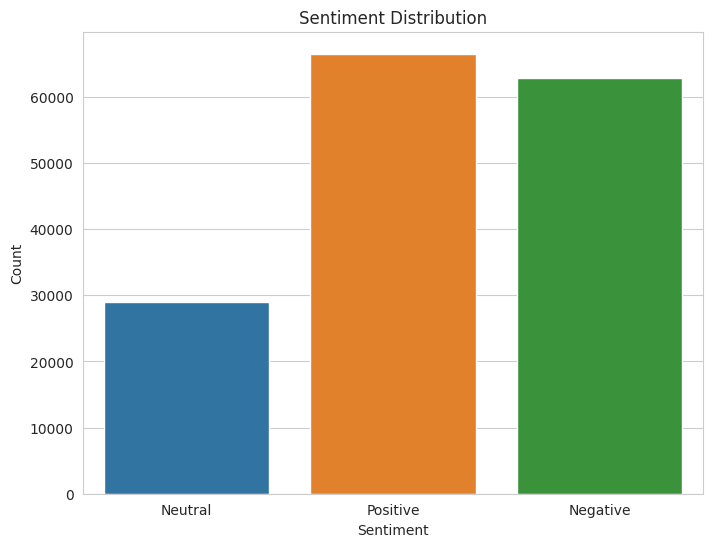

In [125]:
sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Manually reviewing a sample

Reviewing a sample of predicted sentiment labels and comparing them to my own judgment.

In [92]:
sample_data = data.sample(n=50)
print(sample_data[['Tweets', 'Sentiment']])

                                                   Tweets Sentiment
139000  @Luma923 @mercola What has long covid got to d...  Negative
125384  @meonsaint @SkyNews Agree, we know people suff...  Negative
73373   I want to thank some of the investigators/ thi...  Positive
139236  Long Covid alarm as 21% report symptoms after ...   Neutral
24056   @IowaPeg @Nickuk841 @VirusesImmunity The littl...  Negative
111428  @LozzaFox Is your point that there's no such t...   Neutral
9606    Oh the irony.\nDrs with #longcovid many of who...  Negative
61023   Rehabilitation and Covid-19: the Cochrane #Reh...   Neutral
39245   #LongCovid is an enigmatic condition. A Vancou...  Negative
95247   @janemerrick23 Amazing that the Government nev...  Negative
97399   @KenSmithNC There are more than a dozen identi...  Negative
127582  Participating to the same meeting. We need mor...  Positive
74051   @nicklangdale @talkRADIO @JuliaHB1 @ABridgen F...  Positive
48007   @fitterhappierAJ @SeaBree70986269 Well..

In [93]:
for i, row in sample_data.iterrows():
    print("Text:", row['Tweets'])
    print()

Text: @Luma923 @mercola What has long covid got to do with the way Sweden reports its deaths due to COVID-19?

Text: @meonsaint @SkyNews Agree, we know people suffer for months with long Covid

Text: I want to thank some of the investigators/ thinkers whose work we built upon, and which I've found terribly useful in analyzing #LongCOVID and pandemic sequelae. A thread...

Text: Long Covid alarm as 21% report symptoms after five weeks @NicolaKSDavis @guardian 

|#LongCovid #CountLongCovid|
@long_covid 

https://t.co/z0JH0Ar0dT

Text: @IowaPeg @Nickuk841 @VirusesImmunity The little problem with #COVID19 and some crazy #HerdImmunity plans, is that the vast majority of people ??don't die?? but many suffer terribly and remain ill for months. 

Maybe forever. 

Are you ready for that? Are we ready for that as a society?

#LongCovid #apresJ20

Text: @LozzaFox Is your point that there's no such thing as long covid? Or that Hancock shouldn't mention it?

Text: Oh the irony.
Drs with #longcovi

Reviewing the tweets and labeling them on my own for comparison

In [117]:
labels = [
    'Negative', 'Negative', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Negative',
    'Neutral', 'Positive', 'Negative', 'Negative', 'Neutral', 'Negative', 'Neutral',
    'Neutral', 'Positive', 'Neutral', 'Negative', 'Positive', 'Negative', 'Negative',
    'Positive', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Neutral',
    'Negative', 'Negative', 'Neutral', 'Negative', 'Negative', 'Negative', 'Negative',
    'Positive', 'Neutral', 'Negative', 'Negative', 'Positive', 'Neutral', 'Neutral',
    'Neutral', 'Negative', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive',
    'Neutral'
]

sample_data['MySentiment'] = labels
sample_data

,Date,Tweets,Sentiment,MySentiment
139000,2020-12-16 15:41:39+00:00,@Luma923 @mercola What has long covid got to d...,Negative,Negative
125384,2020-12-01 16:25:10+00:00,"@meonsaint @SkyNews Agree, we know people suff...",Negative,Negative
73373,2020-10-16 14:23:58+00:00,I want to thank some of the investigators/ thi...,Positive,Positive
139236,2020-12-16 18:49:55+00:00,Long Covid alarm as 21% report symptoms after ...,Neutral,Neutral
24056,2020-08-28 17:44:19+00:00,@IowaPeg @Nickuk841 @VirusesImmunity The littl...,Negative,Negative
111428,2020-11-16 23:52:37+00:00,@LozzaFox Is your point that there's no such t...,Neutral,Neutral
9606,2020-07-21 20:01:48+00:00,Oh the irony.\nDrs with #longcovid many of who...,Negative,Negative
61023,2020-10-07 22:16:08+00:00,Rehabilitation and Covid-19: the Cochrane #Reh...,Neutral,Neutral
39245,2020-09-18 20:59:46+00:00,#LongCovid is an enigmatic condition. A Vancou...,Negative,Positive
95247,2020-11-02 16:03:21+00:00,@janemerrick23 Amazing that the Government nev...,Negative,Negative


In [95]:
accuracy = accuracy_score(labels, sample_data['Sentiment'])
print('Accuracy on lc2020.csv dataset:', accuracy)

Accuracy on lc2020.csv dataset: 0.72


# Visualizations

## Sentiment distribution over time

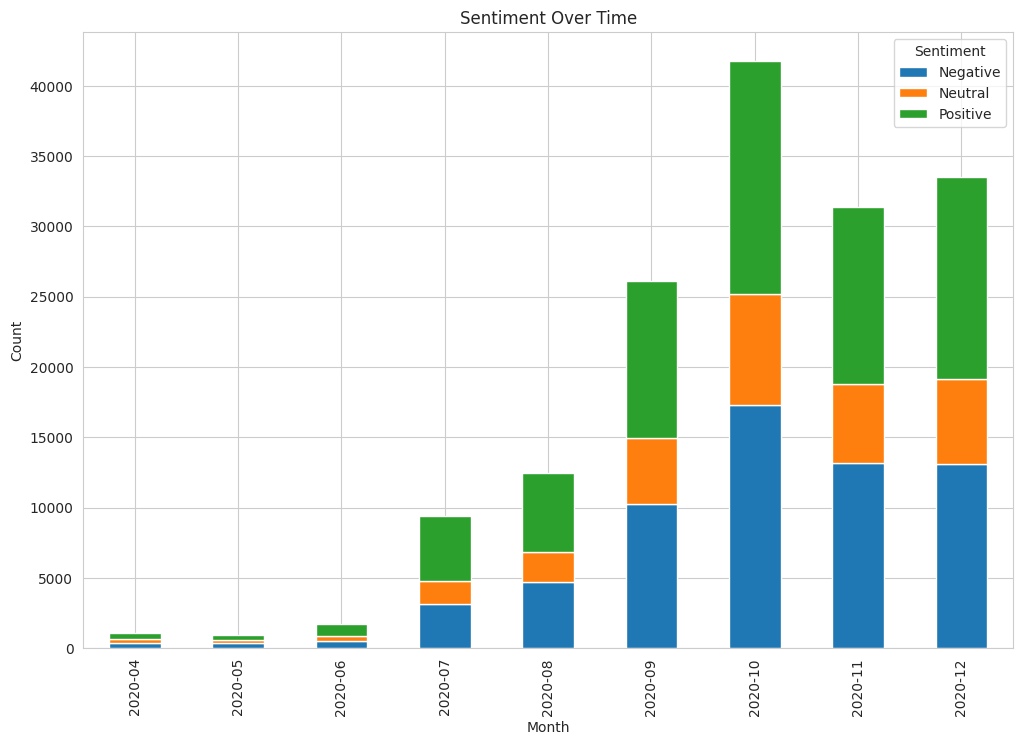

In [129]:
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.strftime('%Y-%m')
sentiment_by_month = data.groupby(['Month', 'Sentiment']).size().unstack().fillna(0)
sentiment_by_month.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Sentiment Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

## Word Cloud for Negative, Neutral and positive sentiment

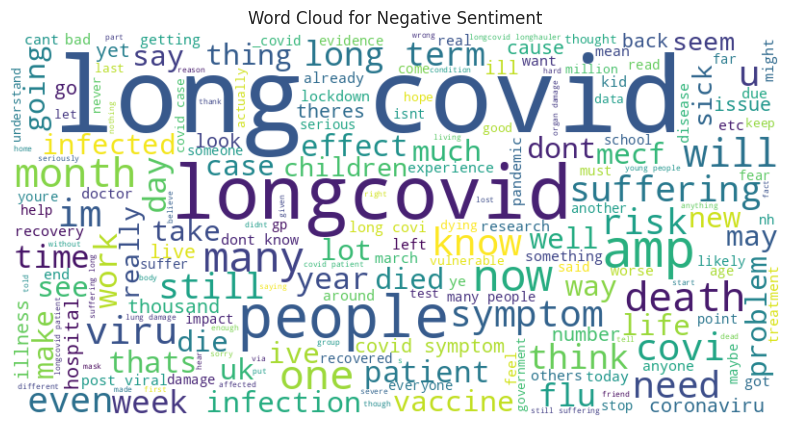

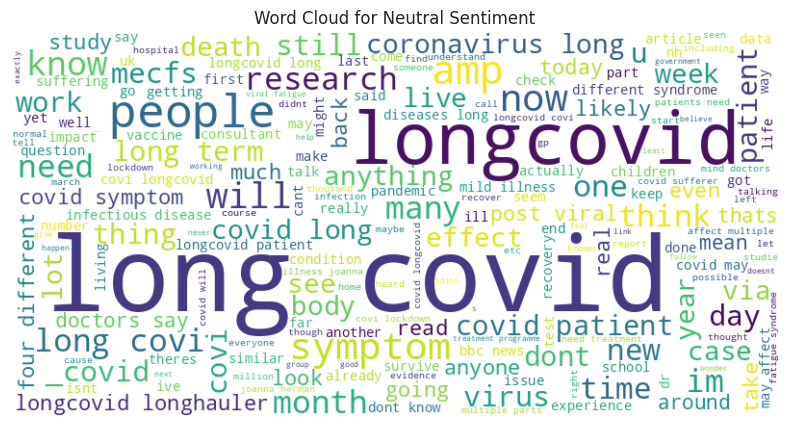

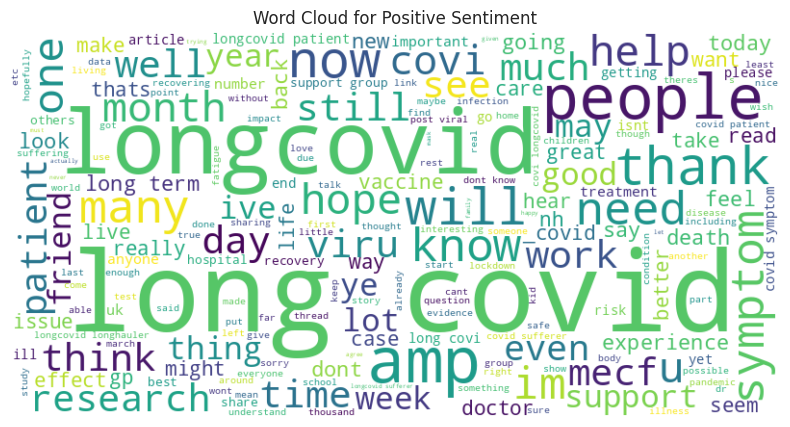

In [130]:
from wordcloud import WordCloud

sentiment_labels = ['Negative', 'Neutral', 'Positive']
for sentiment in sentiment_labels:
    words = ' '.join(data[data['Sentiment'] == sentiment]['PreprocessedTweets'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()

## Sentiment distribution

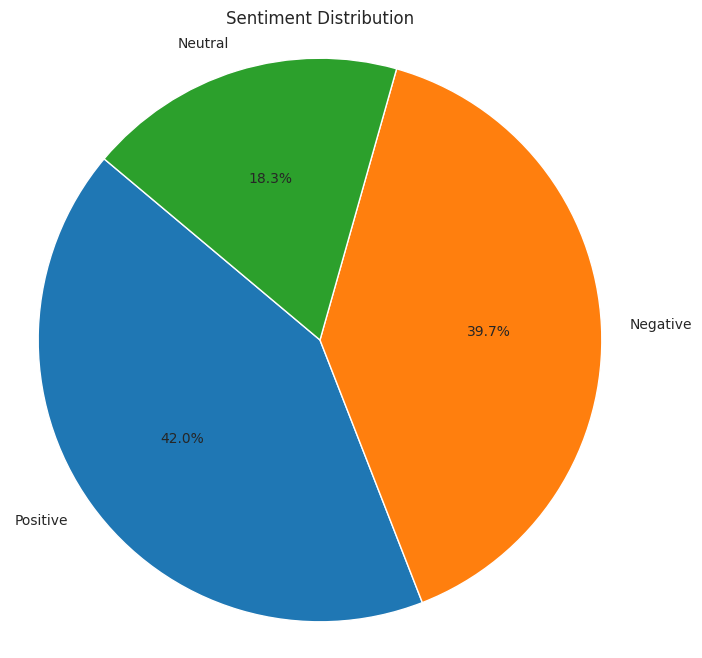

In [132]:
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()